# Tensorflow implementation of temporal parallelisation of Kalman filter and smoother

This notebook implements the algorithms in the paper by S. Särkkä and Á. García-Fernández by leveraging the [Tensorflow](https://www.tensorflow.org/) framework. 

## Author: Adrien Corenflos

## Reference:
Simo Särkkä and Ángel F. García-Fernández (2021). Temporal Parallelization of Bayesian Smoothers.   
IEEE Transactions on Automatic Control, Volume: 66, Issue: 1, Pages 299-306.  
arXiv: https://arxiv.org/abs/1905.13002   
DOI: https://doi.org/10.1109/TAC.2020.2976316

- If you are on Colab don't forget to switch the Runtime (in the tab with the same name) type to GPU.
- If you are using a personal machine, to install tensorflow with GPU support please read TensorFlow [user guide](https://www.tensorflow.org/install).

### Imports

In [1]:
# Python specific imports that will make our job easier and our code prettier
from collections import namedtuple
from functools import partial
import math
import time
from tqdm.auto import trange, tqdm

# TF specific imports that we will use to code the logic
from tensorflow import function
import tensorflow as tf
import tensorflow_probability as tfp

# Auxiliary libraries that we will use to report results and create the data
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

### Utilities
We define some utilities that will make the code more readable

In [3]:
mm = tf.linalg.matmul
mv = tf.linalg.matvec

### Model
In the vein of (put book ref) we consider a simple car tracking model where the car is caracterised by its coordinates and directional speeds $\mathbf{z} = [x, y, \dot{x}, \dot{y}]^\top$ for which only the positional components are observed with some uncertainty. Formally this corresponds to the following state-space model:

\begin{equation}
\begin{split}
  x_k &=  F \, x_{k-1} + q_{k-1},\\
  y_k &=  H \, x_k + r_k,
\end{split}
\end{equation}

where $q_k \sim \mathrm{N}(0,Q)$, $r_k \sim \mathrm{N}(0,R)$, and
 \begin{equation}
  F = \begin{pmatrix}
    1 & 0 & \Delta t & 0 \\
    0 & 1 & 0 & \Delta t \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1
  \end{pmatrix}
  ,\quad
  Q = q \, \begin{pmatrix}
     \frac{\Delta t^3}{3} & 0 & \frac{\Delta t^2}{2} & 0 \\
     0 & \frac{\Delta t^3}{3} & 0 & \frac{\Delta t^2}{2} \\
     \frac{\Delta t^2}{2} & 0 & \Delta t & 0     \\ 
     0 & \frac{\Delta t^2}{2} & 0 & \Delta t
  \end{pmatrix},
\end{equation}

along with
\begin{equation}
  H = \begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 
  \end{pmatrix}, \qquad
  R = \begin{pmatrix}
    \sigma^2 & 0  \\
    0 & \sigma^2 
  \end{pmatrix}.
\end{equation}

which translates into the following code:

In [4]:
StateSpaceModel = namedtuple("StateSpaceModel", ["F", "H", "Q", "R", "m0", "P0", "xdim", "ydim"])

In [5]:
def make_car_tracking_model(q: float, dt: float, r: float, m0: np.ndarray, P0: np.ndarray):
    F = np.eye(4) + dt * np.eye(4, k=2)
    H = np.eye(2, 4)
    Q = np.kron(np.array([[dt**3/3, dt**2/2],
                          [dt**2/2, dt]]), 
                np.eye(2))
    R = r ** 2 * np.eye(2)
    return StateSpaceModel(F, H, q * Q, R, m0, P0, m0.shape[0], H.shape[0])



In [6]:
car_tracking_model = make_car_tracking_model(q=1., dt=0.1, r=0.5, 
                                             m0=np.array([0., 0., 1., -1.]), 
                                             P0=np.eye(4))

So that we can now write some generic code to sample from a SSM:

In [7]:
def get_data(model: StateSpaceModel, T:float, seed:int=0):
    # We first generate the normals we will be using to simulate the SSM:
    rng = np.random.RandomState(seed)
    normals = rng.randn(1 + T, model.xdim + model.ydim)
    
    # Then we allocate the arrays where the simulated path and observations will
    # be stored:
    xs = np.empty((T, model.xdim))
    ys = np.empty((T, model.ydim))

    # So that we can now run the sampling routine:
    Q_chol = sc.linalg.cholesky(model.Q, lower=True)
    R_chol = sc.linalg.cholesky(model.R, lower=True)
    P0_chol = sc.linalg.cholesky(model.P0, lower=True)
    x = model.m0 + P0_chol @ normals[0, :model.xdim]
    for i, norm in enumerate(normals[1:]):
        x = model.F @ x + Q_chol @ norm[:model.xdim]
        y = model.H @ x + R_chol @ norm[model.xdim:]
        xs[i] = x
        ys[i] = y
    return xs, ys

In [8]:
log10T = 4

In [9]:
true_xs, ys = get_data(car_tracking_model, 10 ** log10T, 0)

This corresponds to the following data (truncated at 100 timesteps):

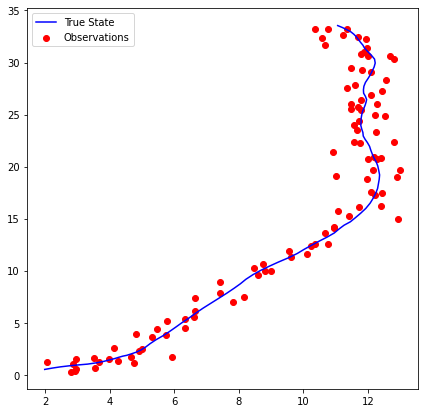

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(true_xs[:100, 0], true_xs[:100, 1], label="True State", color="b")
ax.scatter(*ys[:100].T, label="Observations", color="r")
_ = plt.legend()

### Sequential Kalman filter and smoother
We can now write the Kalman filter and smoother sequential routines in a TensorFlow fashion. For more information on these algorithms, we refer the reader to the book: 

Särkkä, S. (2013). Bayesian filtering and smoothing. Cambridge University Press.

For which an online version is also available on his [webpage](https://users.aalto.fi/~ssarkka/).

#### Filter:

In [11]:
@partial(tf.function, experimental_relax_shapes=True)
def kf(model, observations):
    def body(carry, y):
        m, P = carry
        m = mv(model.F, m)
        P = model.F @ mm(P, model.F, transpose_b=True)+ model.Q

        S = model.H @ mm(P, model.H, transpose_b=True) + model.R

        chol = tf.linalg.cholesky(S)
        Kt = tf.linalg.cholesky_solve(chol, model.H @ P)

        m = m + mv(Kt, y - mv(model.H, m), transpose_a=True)
        P = P - mm(Kt, S, transpose_a=True) @ Kt
        return m, P

    fms, fPs = tf.scan(body, observations, (model.m0, model.P0))
    return fms, fPs


In [12]:
with tf.device('/CPU:0'):
    fms, fPs = kf(car_tracking_model, ys[:100])

#### Smoother:

In [13]:
@partial(tf.function, experimental_relax_shapes=True)
def ks(model, ms, Ps):
    def body(carry, inp):
        m, P = inp
        sm, sP = carry

        pm = mv(model.F, m)
        pP = model.F @ mm(P, model.F, transpose_b=True) + model.Q

        chol = tf.linalg.cholesky(pP)
        Ct = tf.linalg.cholesky_solve(chol, model.F @ P)

        sm = m + mv(Ct, (sm - pm), transpose_a=True)
        sP = P + mm(Ct, sP - pP, transpose_a=True) @ Ct
        return sm, sP

    (sms, sPs) = tf.scan(body, (ms[:-1], Ps[:-1]), (ms[-1], Ps[-1]), reverse=True)
    sms = tf.concat([sms, tf.expand_dims(ms[-1], 0)], 0)
    sPs = tf.concat([sPs, tf.expand_dims(Ps[-1], 0)], 0)
    return sms, sPs


In [14]:
with tf.device('/CPU:0'):
    sms, sPs = ks(car_tracking_model, fms, fPs)

So that we can now plot the result agains the true state and the observations:

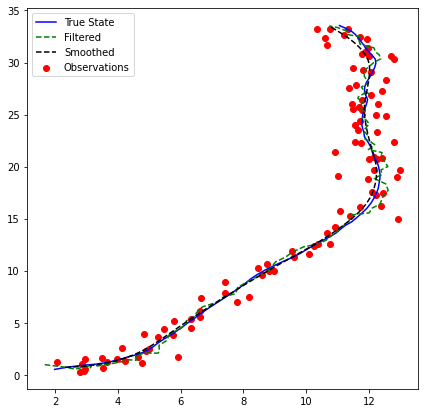

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(true_xs[:100, 0], true_xs[:100, 1], label="True State", color="b")
ax.plot(fms[:100, 0], fms[:100, 1], label="Filtered", color="g", linestyle="--")
ax.plot(sms[:100, 0], sms[:100, 1], label="Smoothed", color="k", linestyle="--")
ax.scatter(*ys[:100].T, label="Observations", color="r")
_ = plt.legend()

#### Filter-Smoother
We can finally combine the filter and the smoother into a single filter-smoother routine:

In [16]:
@partial(tf.function, experimental_relax_shapes=True)
def kfs(model, observations):
    return ks(model, *kf(model, observations))

### Parallel Kalman filter and smoother
Now that we have a baseline for the sequential model, we can go on and implement the parallel version of the routine, leveraging the associative_scan function already offered by TensorFlow Probability ([see this](https://www.tensorflow.org/probability/api_docs/python/tfp/math/scan_associative)). To do this we will need to do a bit more work, but before this let us offer some intuition around what exactly is happening.

#### Prefix-Sum / Associative Scan
Consider the simple problem of computing the cumulative sum of a given array of floats:

In [17]:
array_of_floats = np.arange(2 ** 4, dtype=np.float32)

A simple way to do this would be to iterate (scan) through the array from left to right and accumulate the result as we go:

In [18]:
def cumulative_sum(arr):
    # obviously numpy implements cumulative sums already, but this is for illustrative purposes.
    res = np.empty_like(arr)
    temp = 0.
    for i, val in enumerate(arr):
        temp += val
        res[i] = temp
    return res

In [19]:
cumulative_sum(array_of_floats)

array([  0.,   1.,   3.,   6.,  10.,  15.,  21.,  28.,  36.,  45.,  55.,
        66.,  78.,  91., 105., 120.], dtype=float32)

However, the addition operation has the fundamental property to be associative: $(a+b) + c = a + (b + c)$, under which accumulative scans have been proven to be parallelizable (Blelloch, 1990, see the paper for a reference) up to a span complexity of $O(log(N))$ in the context where many processors are available. If we were to write the algorithm in pure python, it would look like the below:

In [20]:
def prefix_sum(arr):
    # This is for illustration purposes only, and for instance doesn't take into
    # account the case when the array size is not a pure power of 2
    res = np.copy(arr)
    n = res.shape[0]
    log_n  = np.log2(n).astype(int)

    # Up pass
    for d in range(log_n):
        # this loop can't be done in parallel so it defines the span complexity under
        # parallelization
        for i in range(0, n, 2 ** (d + 1)):
            # this should be done in parallel, therefore would not be taken 
            # into account in the span complexity provided we have at least 
            # n / 2^{d+1} cores on our GPU
            i1 = i + 2 ** d - 1
            i2 = i + 2 ** (d + 1) - 1
            res[i2] += res[i1]

    res[-1] = 0

    # Down pass
    for d in range(log_n-1, -1, -1):
        # this loop can't be done in parallel so it defines the span complexity under
        # parallelization
        for i in range(0, n, 2 ** (d + 1)):
            # this should be done in parallel, therefore would not be taken 
            # into account in the span complexity provided we have at least 
            # n / 2^{d+1} cores on our GPU
            i1 = i + 2 ** d - 1
            i2 = i + 2 ** (d + 1) - 1
        
            res[i1], res[i2] = res[i2], res[i1] + res[i2] 
                
    # Extra pass
    res += arr
    
    return res

In [21]:
prefix_sum(array_of_floats)

array([  0.,   1.,   3.,   6.,  10.,  15.,  21.,  28.,  36.,  45.,  55.,
        66.,  78.,  91., 105., 120.], dtype=float32)

#### Filter:

In the case of Kalman filters, one can think of the addition as being the bayesian map operator coming from the fact of "adding" one observation to the model:

\begin{equation}
    p(x_k \mid y_{1:k-1})
    = \int p(x_k \mid x_{k-1})
       \, p(x_{k-1} \mid y_{1:k-1}) \, \mathrm{d}x_{k-1},
\end{equation}

\begin{equation}
    p(x_k \mid y_{1:k})
    = \frac{p(y_k \mid x_k)
       \, p(x_k \mid y_{1:k-1})}
       {\int p(y_k \mid x_k)
          \, p(x_k \mid y_{1:k-1}) \, \mathrm{d}x_k}.
\end{equation}

As it is, this operation on the random variables $x_k$'s is not associative as switching around the observations will result in a completely different result. However S. Särkkä and Á. García-Fernández showed that these could be rewritten in terms of the associative operator given by:

\begin{align*}
    \left(f_{i},g_{i}\right)\otimes\left(f_{j},g_{j}\right) & =\left(f_{ij},g_{ij}\right),
\end{align*}
\begin{align*}
    f_{ij}\left(x\mid z\right) & =\frac{\int g_{j}\left(y\right)f_{j}\left(x\mid y\right)f_{i}\left(y\mid z\right)\mathrm{d}y}{\int g_{j}\left(y\right)f_{i}\left(y\mid z\right)\mathrm{d}y}, \\
    g_{ij}\left(z\right) & =g_{i}\left(z\right)\int g_{j}\left(y\right)f_{i}\left(y\mid z\right)\mathrm{d}y.
\end{align*}


This could in turn be rewritten in terms of the linear equations of the state parameters, which leads to the below algorithm:

##### Initialisation of the associative elements:
We write the function that will initialise them (in parallel) based on the data and the observations:

In [22]:
@partial(tf.function, experimental_relax_shapes=True)
def first_filtering_element(model, y):

    m1 = mv(model.F, model.m0)
    P1 = model.F @ mm(model.P0, model.F, transpose_b=True) + model.Q
    S1 = model.H @ mm(P1, model.H, transpose_b=True) + model.R
    S1_chol = tf.linalg.cholesky(S1)
    K1t = tf.linalg.cholesky_solve(S1_chol, model.H @ P1)

    A = tf.zeros_like(model.F)
    b = m1 + mv(K1t, y - mv(model.H, m1), transpose_a=True)
    C = P1 - mm(K1t, S1, transpose_a=True) @ K1t

    S = model.H @ mm(model.Q, model.H, transpose_b=True) + model.R
    chol = tf.linalg.cholesky(S)
    HF = model.H @ model.F
    eta = mv(HF, 
             tf.squeeze(tf.linalg.cholesky_solve(chol, tf.expand_dims(y, 1)), 1), 
             transpose_a=True)
    J = mm(HF, tf.linalg.cholesky_solve(chol, model.H @ model.F), transpose_a=True)
    return A, b, C, J, eta

@partial(tf.function, experimental_relax_shapes=True)
def generic_filtering_element(model, y):
    S = model.H @ mm(model.Q, model.H, transpose_b=True) + model.R
    chol = tf.linalg.cholesky(S)

    Kt = tf.linalg.cholesky_solve(chol, model.H @ model.Q)
    A = model.F - mm(Kt, model.H, transpose_a=True) @ model.F
    b = mv(Kt, y, transpose_a=True)
    C = model.Q - mm(Kt, model.H, transpose_a=True) @ model.Q

    HF = model.H @ model.F
    eta = mv(HF, 
             tf.squeeze(tf.linalg.cholesky_solve(chol, tf.expand_dims(y, 1)), 1), 
             transpose_a=True)
    
    J = mm(HF, tf.linalg.cholesky_solve(chol, HF), transpose_a=True)
    return A, b, C, J, eta

And we can combine them properly:

In [23]:
@partial(tf.function, experimental_relax_shapes=True)
def make_associative_filtering_elements(model, observations):
    first_elems = first_filtering_element(model, observations[0])
    generic_elems = tf.vectorized_map(lambda o: generic_filtering_element(model, o), 
                                      observations[1:], fallback_to_while_loop=False)
    return tuple(tf.concat([tf.expand_dims(first_e, 0), gen_es], 0) 
                 for first_e, gen_es in zip(first_elems, generic_elems))


##### Associative filtering operator
We now define the associative filtering operator

In [24]:
@partial(tf.function, experimental_relax_shapes=True)
def filtering_operator(elems):
    elem1, elem2 = elems

    A1, b1, C1, J1, eta1 = elem1
    A2, b2, C2, J2, eta2 = elem2
    dim = A1.shape[0]
    I = tf.eye(dim, dtype=A1.dtype, )

    temp = tf.linalg.solve(I + C1 @ J2, tf.transpose(A2), adjoint=True)
    A = mm(temp, A1, transpose_a=True)
    b = mv(temp, b1 + mv(C1, eta2), transpose_a=True) + b2
    C = mm(temp, mm(C1, A2, transpose_b=True), transpose_a=True) + C2

    temp = tf.linalg.solve(I + J2 @ C1, A1, adjoint=True)
    eta = mv(temp, eta2 - mv(J2, b1), transpose_a=True) + eta1
    J = mm(temp, J2 @ A1, transpose_a=True) + J1

    return A, b, C, J, eta

##### Parallel routine
And we can now combine all these to compute the filtering result in parallel:

In [25]:
@partial(tf.function, experimental_relax_shapes=True)
def pkf(model, observations, max_parallel=10000):
    initial_elements = make_associative_filtering_elements(model, observations)
    def vectorized_operator(a, b):
        return tf.vectorized_map(filtering_operator, (a, b), fallback_to_while_loop=False)
    final_elements = tfp.math.scan_associative(vectorized_operator, 
                                               initial_elements, 
                                               max_num_levels=math.ceil(math.log2(max_parallel)))
    return final_elements[1], final_elements[2]

That we can compare with the sequential one:

In [26]:
with tf.device('/GPU:0'):
    pfms, pfPs = pkf(car_tracking_model, ys[:100])

In [27]:
np.abs(pfms - fms).max()

5.861977570020827e-14

#### Smoother:


The parallel implementation of the smoother follows similar principles and we refer the reader to the paper for more details about the associative formulation.

##### Initialisation of the associative elements:
We now write the function that will initialise them (in parallel) based on the data and the observations:

In [28]:
@partial(tf.function, experimental_relax_shapes=True)
def last_smoothing_element(m, P):
    return tf.zeros_like(P), m, P

@partial(tf.function, experimental_relax_shapes=True)
def generic_smoothing_element(model, m, P):
    Pp = model.F @ mm(P, model.F, transpose_b=True) + model.Q

    chol = tf.linalg.cholesky(Pp)
    E  = tf.transpose(tf.linalg.cholesky_solve(chol, model.F @ P))
    g  = m - mv(E @ model.F, m)
    L  = P - E @ mm(Pp, E, transpose_b=True)
    return E, g, L

And we can combine them properly:

In [29]:
@partial(tf.function, experimental_relax_shapes=True)
def make_associative_smoothing_elements(model, filtering_means, filtering_covariances):
    last_elems = last_smoothing_element(filtering_means[-1], filtering_covariances[-1])
    generic_elems = tf.vectorized_map(lambda o: generic_smoothing_element(model, o[0], o[1]), 
                                      (filtering_means[:-1], filtering_covariances[:-1]),
                                      fallback_to_while_loop=False)
    return tuple(tf.concat([gen_es, tf.expand_dims(last_e, 0)], axis=0) 
                 for gen_es, last_e in zip(generic_elems, last_elems))

##### Associative smoothing operator
We now define the associative smoothing operator

In [30]:
@partial(tf.function, experimental_relax_shapes=True)
def smoothing_operator(elems):
    elem1, elem2 = elems
    E1, g1, L1 = elem1
    E2, g2, L2 = elem2

    E = E2 @ E1
    g = mv(E2, g1) + g2
    L = E2 @ mm(L1, E2, transpose_b=True) + L2

    return E, g, L

##### Parallel routine
And we can now combine all these to compute the smoothing result in parallel:

In [31]:
@partial(tf.function, experimental_relax_shapes=True)
def pks(model, filtered_means, filtered_covariances, max_parallel=10000):
    initial_elements = make_associative_smoothing_elements(model, filtered_means, filtered_covariances)
    reversed_elements = tuple(tf.reverse(elem, axis=[0]) for elem in initial_elements)
    def vectorized_operator(a, b):
        return tf.vectorized_map(smoothing_operator, (a, b), fallback_to_while_loop=False)
    final_elements = tfp.math.scan_associative(vectorized_operator, 
                                               reversed_elements, 
                                               max_num_levels=math.ceil(math.log2(max_parallel)))
    return tf.reverse(final_elements[1], axis=[0]), tf.reverse(final_elements[2], axis=[0])

That we can compare with the sequential one:

In [32]:
with tf.device('/GPU:0'):
    psms, psPs = pks(car_tracking_model, pfms, pfPs)

In [33]:
np.abs(psms - sms).max()

5.861977570020827e-14

#### Filter-Smoother:
Finally we can combine all these functions into one filter-smoother routine.

In [34]:
@partial(tf.function, experimental_relax_shapes=True)
def pkfs(model, observations, max_parallel=10000):
    return pks(model, *pkf(model, observations, max_parallel), max_parallel)

### Runtime comparison

To compare the runtime of both methods we will compile the routines on GPU and CPU and modify the size of the observation input fed to the routines. It is noteworthy that the parallel version compilation time will depend on the "max_parallel" parameter which defines the depth of the recursion tree compiled (see the [docstring of the method](https://github.com/tensorflow/probability/blob/bf84eb67f342e332b7c09b8f435ba534cd91725e/tensorflow_probability/python/math/scan_associative.py#L210) for more details). A good rule of thumb would be to set it to the number of cores of your GPU (check it with !nvidia-smi in a code cell).

In [35]:
input_sizes = np.logspace(2, log10T, num=10, base=10).astype(int)

In [36]:
n_iter = 5

In [37]:
def get_average_runtimes(func, n_iter, car_model, observations):
    runtimes = np.empty(input_sizes.shape)
    for i, input_size in tqdm(enumerate(input_sizes), total=runtimes.shape[0]):
        observation_slice = observations[:input_size]
        _ = func(car_model, observation_slice)  # compilation run
        tic = time.time()
        for _ in trange(n_iter, leave=False):
            res = func(car_model, observation_slice)
        runtimes[i] = (time.time() - tic) / n_iter
    return runtimes

In [38]:
with tf.device('/CPU:0'):
    cpu_ys = tf.constant(ys)
    cpu_car_tracking_model = StateSpaceModel(*(tf.constant(v) for v in car_tracking_model))
    cpu_sequential_runtimes = get_average_runtimes(kfs, n_iter, cpu_car_tracking_model, cpu_ys)
    cpu_parallel_runtimes = get_average_runtimes(lambda *args :pkfs(*args, max_parallel=int(input_sizes[-1])), 
                                                 n_iter, cpu_car_tracking_model, cpu_ys)
    
    
with tf.device('/GPU:0'):
    gpu_ys = tf.constant(ys)
    gpu_car_tracking_model = StateSpaceModel(*(tf.constant(v) for v in car_tracking_model))
    gpu_sequential_runtimes = get_average_runtimes(kfs, n_iter, gpu_car_tracking_model, gpu_ys)
    gpu_parallel_runtimes = get_average_runtimes(lambda *args :pkfs(*args, max_parallel=int(input_sizes[-1])), 
                                                 n_iter, gpu_car_tracking_model, gpu_ys)

In [ ]:
pkfs.pretty_printed_concrete_signatures()

In [ ]:
kfs.pretty_printed_concrete_signatures()

And we can plot these:

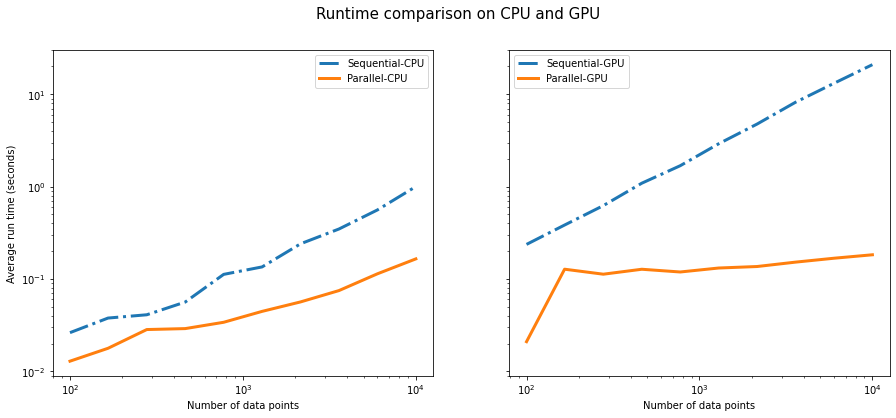

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharex=True, sharey=True)
axes[0].loglog(input_sizes, cpu_sequential_runtimes, label="Sequential-CPU", linestyle="-.", linewidth=3)
axes[0].loglog(input_sizes, cpu_parallel_runtimes, label="Parallel-CPU", linewidth=3)
axes[0].legend()

axes[1].loglog(input_sizes, gpu_sequential_runtimes, label="Sequential-GPU", linestyle="-.", linewidth=3)
axes[1].loglog(input_sizes, gpu_parallel_runtimes, label="Parallel-GPU", linewidth=3)
_ = axes[0].set_ylabel("Average run time (seconds)")

for ax in axes:
    _ = ax.set_xlabel("Number of data points")

_ = fig.suptitle("Runtime comparison on CPU and GPU", size=15)
_ = axes[1].legend()

It is noteworthy that tensorflow has some multi-threading happening in the background, which is probably why we get a better performance for the parallel algorithm on CPU.

In [41]:
tf.__version__

'2.4.0'